In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import random
import urllib.request
import os
from dotenv import load_dotenv
from pathlib import Path

env_path = Path('.') / '.czi.env'
load_dotenv(dotenv_path=env_path)

# Configure the data dir path in .czi.env located in this directory
DATA_DIR_PATH = os.environ.get("DATA_DIR_PATH")
print(f'Using data directory {DATA_DIR_PATH}')

RAW_FILE_PATH = f'{DATA_DIR_PATH}/raw.tar.gz'
LINKED_FILE_PATH = f'{DATA_DIR_PATH}/linked.tar.gz'
RAW_TAR_URL = "https://datadryad.org/stash/downloads/file_stream/1822384"
LINKED_TAR_URL = "https://datadryad.org/stash/downloads/file_stream/1822388"
FILTERED_CZI_SOFTWARE_CSV = 'czi_software.csv'
FULL_FILE_PATH = f'{DATA_DIR_PATH}/{FILTERED_CZI_SOFTWARE_CSV}'

SAMPLED_100k_CZI_CSV = 'sample_100000.csv'

Using data directory <retracted>


In [2]:
# Prepare data directory and check if files exist to avoid duplicate large downloads / expensive computes
raw_exists = False
linked_exists = False
full_exists = False
try:
    os.makedirs(DATA_DIR_PATH)
except FileExistsError:
    raw_exists = os.path.isfile(RAW_FILE_PATH)
    linked_exists = os.path.isfile(LINKED_FILE_PATH)
    full_exists = os.path.isfile(FULL_FILE_PATH)

In [3]:
# Prepare a progressbar to track download progress
import progressbar

class DownloadProgressBar():
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar=progressbar.ProgressBar(maxval=total_size)
            self.pbar.start()

        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()

In [4]:
# Retrieve data from CZI dataset into data directory
import tarfile
if not linked_exists:
    urllib.request.urlretrieve(LINKED_TAR_URL, LINKED_FILE_PATH, DownloadProgressBar())
    with tarfile.open(LINKED_FILE_PATH) as linked_tar:
        linked_tar.extractall(f'{DATA_DIR_PATH}/linked/')

In [5]:
if not raw_exists:
    urllib.request.urlretrieve(RAW_TAR_URL, RAW_FILE_PATH, DownloadProgressBar())
    with tarfile.open(RAW_FILE_PATH) as raw_tar:
        raw_tar.extractall(f'{DATA_DIR_PATH}/raw/')
    # gunzip needed files
    import gzip
    import shutil
    for gzip_file in [
        f'{DATA_DIR_PATH}/raw/raw/comm_raw.tsv.gz',
        f'{DATA_DIR_PATH}/raw/raw/non_comm_raw.tsv.gz',
        f'{DATA_DIR_PATH}/raw/raw/publishers_collections_raw.tsv.gz',
    ]:
        with gzip.open(gzip_file, 'rb') as f_in:
            with open(gzip_file[:-3], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

In [6]:
# Define dtypes for dataset

_meta = {
    'Unnamed: 0': 'object',
    'license': 'str',
    'location': 'str',
    'pmcid': 'object',
    'pmid': 'object',
    'doi': 'object',
    'pubdate': 'object',
    'source': 'object',
    'number': 'object',
    'text': 'str',
    'software': 'str',
    'version': 'str',
    'ID': 'str',
    'curation_label': 'str',
    'software_upper': 'str',
    'mention_counts': 'int64',
}

if not full_exists:
    #Take a look at the data and basic cleaning
    # Use dask, as we're dealing with potentially larger-than-memory data (e.g. the raw publishers mentions dataset has 10+GB)
    import dask.dataframe as dd

    # Read TSV into a single dataframe, brute-force mapping all values to strings
    df_czi = dd.concat([
        dd.read_csv(f'{DATA_DIR_PATH}/raw/raw/comm_raw.tsv', sep='\t', converters={i: str for i in range(14771000)}),
        dd.read_csv(f'{DATA_DIR_PATH}/raw/raw/non_comm_raw.tsv', sep='\t', converters={i: str for i in range(4547000)}),
        dd.read_csv(f'{DATA_DIR_PATH}/raw/raw/publishers_collections_raw.tsv', sep='\t', converters={i: str for i in range(48165000)})
    ],
    ignore_index=True)

    # Filter only curated software
    df_filtered_czi = df_czi.loc[df_czi['curation_label'] == 'software']
    
    # Add a new column with software names in uppercase for brute force deduplication
    df_filtered_czi['software_upper'] = df_filtered_czi['software'].str.upper()
    
    # Add a column that contains value counts for software names
    df_filtered_czi['mention_counts'] = df_filtered_czi['software_upper'].map(df_filtered_czi['software_upper'].value_counts())
    
    # Save the whole humungous dataframe to a single file
    df_filtered_czi.to_csv(f"{DATA_DIR_PATH}/{FILTERED_CZI_SOFTWARE_CSV}", index=True, encoding='utf-8-sig', single_file=True)
    full_exists = True

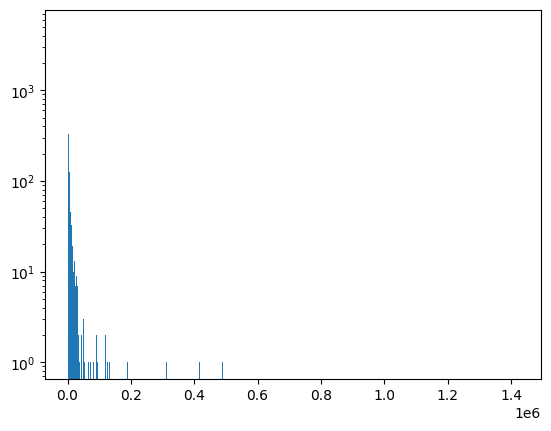

In [7]:
import dask.dataframe as dd
ddf_filtered_czi = dd.read_csv(f"{DATA_DIR_PATH}/{FILTERED_CZI_SOFTWARE_CSV}", encoding='utf-8-sig', dtype=_meta)

software_series = ddf_filtered_czi.software
distinct_software_counts = software_series.value_counts()

#This is what our data looks like on a log scale
plt.hist(distinct_software_counts, bins=1000)
plt.yscale('log', nonpositive='clip')
plt.savefig(f'{DATA_DIR_PATH}/czi_full_citation_histogram.png')
with open(f'{DATA_DIR_PATH}/software_mentions_total', 'w') as tf:
    tf.write(str(ddf_filtered_czi.index.size.compute()))

with open(f'{DATA_DIR_PATH}/distinct_software_mentions_total', 'w') as tf:
    tf.write(str(distinct_software_counts.size.compute()))

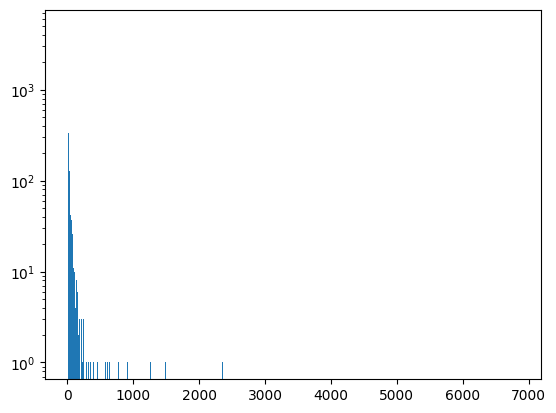

In [8]:
# Take a random stratified proportionate sample of 100,000 rows, and save as CSV
SAMPLE_SIZE = 100000

idx = ddf_filtered_czi.index.size.compute()

# Take a stratified sample (on software name) of ~100k rows

ddf_sample = ddf_filtered_czi.groupby('software_upper', group_keys=False).apply(
    lambda x: x.sample(
        int(
            np.rint(SAMPLE_SIZE * len(x) / idx)
        )), meta = _meta
).sample(frac=1).reset_index(drop=True)

# Save sample

ddf_sample.to_csv(f"{DATA_DIR_PATH}/{SAMPLED_100k_CZI_CSV}", index=True, encoding='utf-8-sig', single_file=True)

software_sample_series = ddf_sample.software
distinct_software_sample_counts = software_sample_series.value_counts()

# Save the histogram and data count for comparison with the full data
plt.hist(distinct_software_sample_counts,bins=1000)
plt.yscale('log', nonpositive='clip')
plt.savefig(f'{DATA_DIR_PATH}/czi_100000_sample_citation_histogram.png')
with open(f'{DATA_DIR_PATH}/software_mentions_sample', 'w') as tf:
    tf.write(str(ddf_sample.index.size.compute()))
    
with open(f'{DATA_DIR_PATH}/distinct_software_mentions_sample', 'w') as tf:
    tf.write(str(distinct_software_sample_counts.size.compute()))

In [9]:
# Population is non-normal (see czi_100000_sample_citation_histogram.png) so to test variances use Levene's test,
# Comparing the equality of variance between the full dataset and the sample
# https://www.itl.nist.gov/div898/handbook/eda/section3/eda35a.htm

from scipy.stats import levene

stat,p=levene(distinct_software_counts, distinct_software_sample_counts)
print(p)
#Actual values of variances
varval = [np.var(x, ddof=1) for x in [distinct_software_counts.compute(), distinct_software_sample_counts.compute()]]


with open(f'{DATA_DIR_PATH}/sample_v_full_variance_p_values', 'w') as pf:
    pf.write(f'p: {str(p)}\n{str(varval)}')

# If this gives small p-values, populations don't have equal variances (to be expected)

3.2841353138477684e-16


In [10]:
# Take one sample per software group

ddf_distinct_software_sample = ddf_sample.groupby('software_upper').apply(lambda x: x.sample(1), meta=_meta).reset_index(drop=True)
ddf_distinct_software_sample.to_csv(f'{DATA_DIR_PATH}/sample_distinct_software.csv', index=True, encoding='utf-8-sig', single_file=True)

# Split the resulting dataframe into one with the top 100 most mentioned software
# and one with a sample (n=1000) of the remainder

df_top100 = ddf_distinct_software_sample.nlargest(100, 'mention_counts')
df_top100.to_csv(f'{DATA_DIR_PATH}/sample_top_100_counts.csv', index=True, encoding='utf-8-sig', single_file=True)
ddf_distinct_software_sample = dd.read_csv(f'{DATA_DIR_PATH}/sample_distinct_software.csv', dtype=_meta)
df_without_top100 = ddf_distinct_software_sample.nsmallest(len(ddf_distinct_software_sample)-100, 'mention_counts')
sample_1000 = df_without_top100.sample(frac=0.14564521).compute()  # Fraction for 1000 of 6866 (size of the distinct sample - top 100)
sample_1000.to_csv(f'{DATA_DIR_PATH}/sample_1000_counts.csv', index=True, encoding='utf-8-sig')